In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import gymnasium as gym
from sklearn.preprocessing import PolynomialFeatures

In [2]:
class AgentGrad():
    def __init__(self, obs_dim, act_dim, epsilon=0.2, policy='epsilon-greedy'):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.epsilon = epsilon
        self.policy = policy



    def a_epsilon_greedy(self, q_alla):
        if np.random.rand() < self.epsilon:
            out_a = int(np.random.choice(self.act_dim))
        else:
            out_a = torch.argmax(q_alla).item()
        return out_a
    
    def select_action(self, s):
        if self.policy == 'epsilon-greedy':
            return self.a_epsilon_greedy(s)


# Gradient Sarsa($\lambda$)

In [6]:
dtype = torch.float
device = torch.device("cpu")
Q_model = torch.nn.Sequential(
    nn.Linear(15, 64, bias=True), # 0
    nn.ReLU(),
    nn.Linear(64, 32, bias=True), # 0
    nn.ReLU(),
    nn.Linear(32, 16, bias=True), # 0
    nn.ReLU(),
    nn.Linear(16, 2, bias=True), # 0

)
params = []
for nni in [0, 2, 4, 6]:
    params.append(Q_model[nni].weight)
    params.append(Q_model[nni].bias)

for param in params:
    torch.nn.init.normal_(param, 0, 1e-5)


pnf = PolynomialFeatures(2)  # 15


In [7]:
obs_dim = 15
act_dim = 2
gamma = 0.98
alpha = 0.001
epsilon=0.8
lamb = 0.6

ag = AgentGrad(obs_dim=obs_dim, act_dim=act_dim, epsilon=epsilon)
env = gym.make("CartPole-v1")

Niters = 10000
all_ts = np.zeros(Niters)

for ni in range(Niters):
    if ((ni+1) %  1000== 0) and (ni > 0):
        ag.epsilon = ag.epsilon / 1.5
        alpha = alpha / 1.5
    if ((ni+1) %  100== 0) and (ni > 0):
        print('episode %d, t=%d, epsilon=%0.4f, alpha=%0.6f'% (ni+1, all_ts[ni-1], ag.epsilon, alpha))
    t = 0
    terminated, truncated = False, False

    s_ori, _ = env.reset()
    s = pnf.fit_transform(s_ori.reshape(1, -1)).reshape(obs_dim)
    s_tensor = torch.from_numpy(s)
    with torch.no_grad():
        allq = Q_model(s_tensor)
    a = ag.select_action(allq)

    z_traces = []
    for param in params:
        z_traces.append(torch.zeros(param.shape, dtype=torch.float))
    
    
    Q_model.zero_grad()
    
    while (terminated is False) and (truncated is False) :
        if (t+1) % 5000 == 0:
            print('Time = %d'%(t+1))

        s_tensor = torch.from_numpy(s)
        allq = Q_model(s_tensor)
        q_now = allq[a]

        s_next_ori, r_next, terminated, truncated, _ = env.step(a)
        s_next = pnf.fit_transform(s_next_ori.reshape(1, -1)).reshape(obs_dim)
        s_next_tensor = torch.from_numpy(s_next)
        with torch.no_grad():
            allq_next = Q_model(s_next_tensor)
        a_next = ag.select_action(allq_next)
        q_next = allq_next[a_next]

        if terminated:
            td_err = r_next - q_now
        else:
            td_err = r_next + gamma * q_next - q_now

        loss = torch.square(td_err)/2

        loss.backward()
        with torch.no_grad():
            for parami in range(len(params)):
                z_traces[parami] = gamma * lamb *z_traces[parami] + params[parami].grad
                params[parami] -= z_traces[parami] * alpha
            Q_model.zero_grad()
        
        s = s_next
        a = a_next
        t += 1
        
    all_ts[ni] = t


episode 99, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 199, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 299, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 399, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 499, t=9, epsilon=0.1000, Terminated = True, Truncated = False
episode 599, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 699, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 799, t=9, epsilon=0.1000, Terminated = True, Truncated = False
episode 899, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 999, t=12, epsilon=0.1000, Terminated = True, Truncated = False
episode 1099, t=10, epsilon=0.1000, Terminated = True, Truncated = False
episode 1199, t=9, epsilon=0.1000, Terminated = True, Truncated = False
episode 1299, t=12, epsilon=0.1000, Terminated = True, Truncated = False
episode 1399, t=10, epsilon=0.1000, Terminated = True, Truncated 

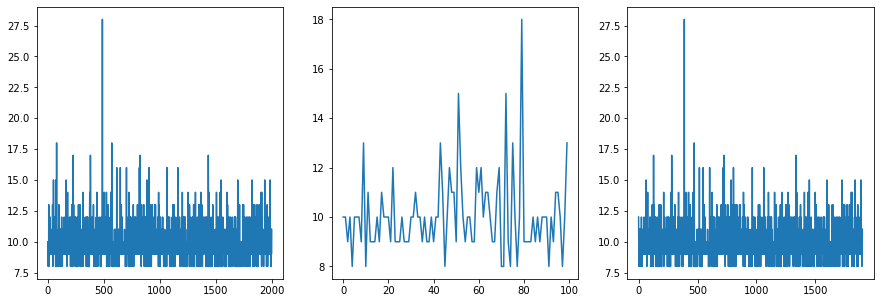

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(all_ts)
ax[1].plot(all_ts[:100])
ax[2].plot(all_ts[-100:])